In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn import cluster
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from scipy import signal

# Problem 1: K-Means Clustering
**K-Means Clustering** is an unsupervised learning algorithm for data grouping. In image segmen- tation, it can be applied to partition image pixels into different groups based on the associated pixel values or features. In this problem, you will learn how to segment the provided image by using K-means clustering.

In [2]:
img = cv2.imread('data/bird.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## 1-1. cluster with only RGB values

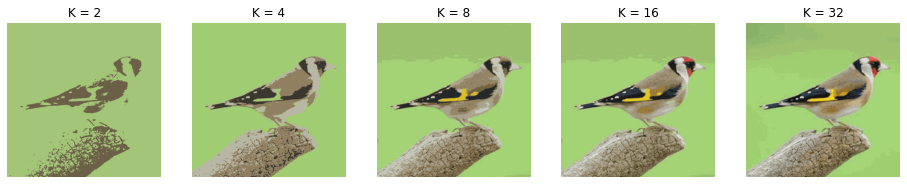

In [3]:
Z = img.reshape((-1, 3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 1.0)
Ks = [2, 4, 8, 16, 32]
plt.figure(figsize=(16,12))

for i, K in enumerate(Ks):
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res = res.reshape((img.shape))

    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.title("K = {}".format(K))
    plt.imshow(res)
    
plt.show()

## 1-2. cluster with RGB values and the location

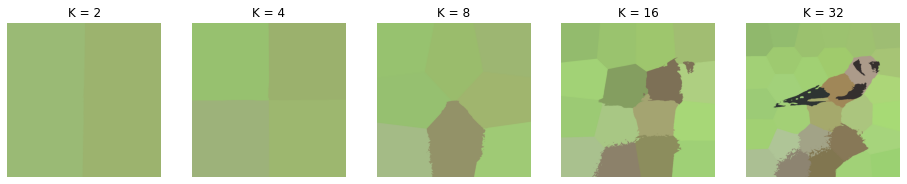

In [4]:
def km_clust(array, n_clusters):
    
    # Define the k-means clustering problem
    k_m = cluster.KMeans(n_clusters=n_clusters, n_init=4)
    # Solve the k-means clustering problem
    k_m.fit(array)
    # Get the coordinates of the clusters centres
    center = k_m.cluster_centers_
    # Get the label of each point
    label = k_m.labels_
    return(label, center)

h, w, c = img.shape

Z = np.zeros((h, w, c+2))
for h in range(len(img)):
    for w in range(len(img[h])):
        Z[h][w] = np.append(img[h][w], [[h], [w]])
Z = Z.reshape(-1, 5)

Ks = [2, 4, 8, 16, 32]
plt.figure(figsize=(16,12))

for i, K in enumerate(Ks):
    label, center = km_clust(Z, K)

    # Now convert back into uint8, and make original image
    center = np.uint8(center[:, :3])
    res = center[label.flatten()]
    res = res.reshape((img.shape))

    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.title("K = {}".format(K))
    plt.imshow(res)
    
plt.show()

## 1-3. explain the differences between the two methods under the same K.

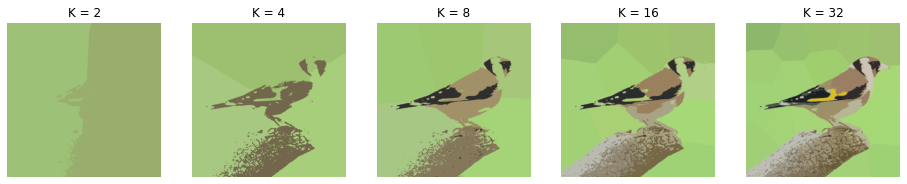

In [5]:
def km_clust(array, n_clusters):
    
    # Define the k-means clustering problem
    k_m = cluster.KMeans(n_clusters=n_clusters, n_init=4)
    # Solve the k-means clustering problem
    k_m.fit(array)
    # Get the coordinates of the clusters centres
    center = k_m.cluster_centers_
    # Get the label of each point
    label = k_m.labels_
    return(label, center)

h, w, c = img.shape

Z = np.zeros((h, w, c+2))
for h in range(len(img)):
    for w in range(len(img[h])):
        Z[h][w] = np.append(img[h][w], [[h/4], [w/4]])
Z = Z.reshape(-1, 5)

Ks = [2, 4, 8, 16, 32]
plt.figure(figsize=(16,12))

for i, K in enumerate(Ks):
    label, center = km_clust(Z, K)

    # Now convert back into uint8, and make original image
    center = np.uint8(center[:, :3])
    res = center[label.flatten()]
    res = res.reshape((img.shape))

    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.title("K = {}".format(K))
    plt.imshow(res)
    
plt.show()

# Problem 2: Principal Component Analysis
**Principal component analysis** (PCA) is a technique of dimensionality reduction, which linearly maps data onto a lower-dimensional space, so that the variance of the projected data in the associated dimensions would be maximized. In this problem, you will perform PCA on a dataset of face images.

In [6]:
X_train, X_test = [], []
Y_train, Y_test = [], []
for i in range(1, 41):
    for j in range(1, 10):
        img = cv2.imread('data/p2_data/{}_{}.png'.format(i, j), cv2.IMREAD_GRAYSCALE)
        X_train.append(img)
        Y_train.append(i)
    img = cv2.imread('data/p2_data/{}_10.png'.format(i), cv2.IMREAD_GRAYSCALE)
    X_test.append(img)
    Y_test.append(i)

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(360, 56, 46) (360,)
(40, 56, 46) (40,)


## 2-1. mean face & first four eigenfaces

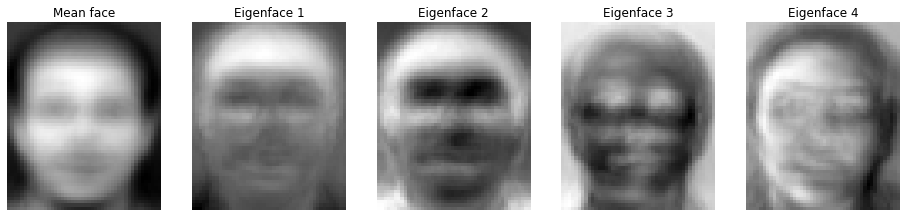

In [7]:
pca = PCA()
pca.fit(X_train.reshape(len(Y_train), -1))

plt.figure(figsize=(16,12))
plt.subplot(1, 5, 1)
plt.axis('off')
plt.title("Mean face")
plt.imshow(pca.mean_.reshape(X_train[0].shape), cmap='gray')

for i in range(4):
    plt.subplot(1, 5, i+2)
    plt.axis('off')
    plt.title("Eigenface {}".format(i+1))
    plt.imshow(pca.components_[i].reshape(X_train[0].shape), cmap='gray')
    
plt.show()

## 2-2. Reconstruct person2 image1 using the first n = 3, 50, 170, 240, 345 eigenfaces
## 2-3. compute the mean squared error

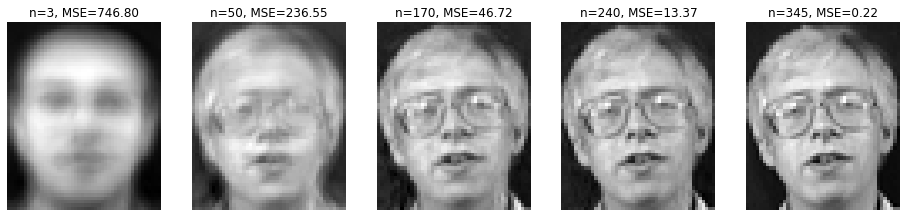

In [8]:
img = cv2.imread('data/p2_data/2_1.png', cv2.IMREAD_GRAYSCALE).reshape(1, -1)
a = pca.transform(img)

plt.figure(figsize=(16,12))
n_components = [3, 50, 170, 240, 345]
for i, n in enumerate(n_components):
    face = np.zeros(img.shape)
    for j in range(n):
        face = face + a[0][j]*pca.components_[j]
    face = face+pca.mean_
    MSE = np.mean((face-img)**2)
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.title("n={}, MSE={:.2f}".format(n, MSE))
    plt.imshow(face.reshape(X_train[0].shape), cmap='gray')

## 2-4. cross-validation results

In [9]:
reduced_X_train = pca.transform(X_train.reshape(len(Y_train), -1))
K = [1, 3, 5]
N = [3, 50, 170]

for k in K:
    print("k={}".format(k))
    knn = KNeighborsClassifier(n_neighbors=k)
    for n in N:
        print('   n={}, '.format(n), end='')
        score = cross_val_score(knn, reduced_X_train[:, :n], Y_train, cv=3)
        print('score={:.4f}'.format(score.mean()))

k=1
   n=3, score=0.6500
   n=50, score=0.9611
   n=170, score=0.9556
k=3
   n=3, score=0.6111
   n=50, score=0.9000
   n=170, score=0.8889
k=5
   n=3, score=0.5611
   n=50, score=0.8472
   n=170, score=0.8222


## 2-5. recognition rate of the testing set

In [10]:
k=1
n=50

reduced_X_test = pca.transform(X_test.reshape(len(Y_test), -1))

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(reduced_X_train[:, :n], Y_train)

print('accuracy = {}'.format(knn.score(reduced_X_test[:, :n], Y_test)))

accuracy = 0.925


# Problem 3: Image Filtering 
**Image filtering** is a basic method to smoothen or sharpen an image. The general operation of image filtering is to compute the function of local neighborhood and output the new value for each pixel of interest. 

In [11]:
img = cv2.imread('data/lena.png', cv2.IMREAD_GRAYSCALE)

## 3-1. 2D Gaussian filter

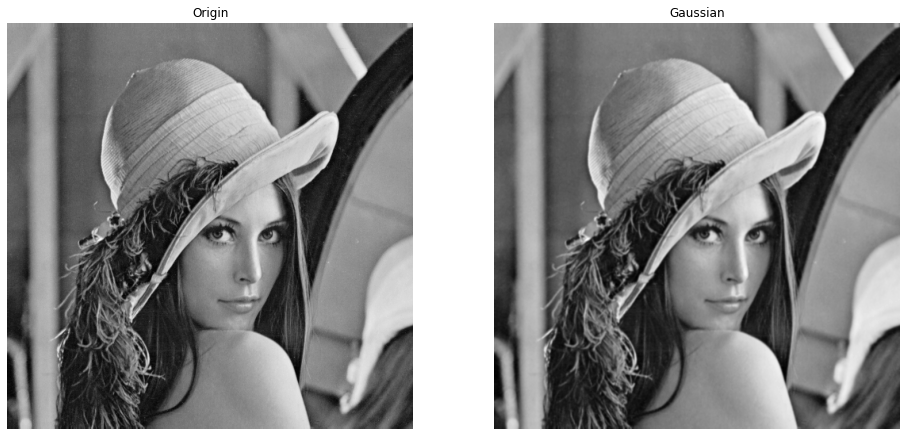

In [12]:
plt.figure(figsize=(16,12))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("Origin")
plt.imshow(img, cmap='gray')

#3*3 Gassian filter
sigma = 1/(2*np.log(2))
x, y = np.mgrid[-1:2, -1:2]
gaussian_kernel = np.exp(-(x**2+y**2)/(2*sigma*sigma)) / (2*np.pi*sigma*sigma)

#Normalization
gaussian_kernel = gaussian_kernel / gaussian_kernel.sum()

img_gaussian = signal.convolve2d(img, gaussian_kernel, boundary='symm', mode='same')


plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Gaussian")
plt.imshow(img_gaussian, cmap='gray')
plt.show()

## 3-2. Detecting edges
\\( k_x=\begin{bmatrix}
          0.5 & 0 & -0.5
        \end{bmatrix}
\\)

\\( k_y=\begin{bmatrix}
          0.5 \\ 0 \\ -0.5
        \end{bmatrix}
\\)

In [13]:
kx = np.array([[0.5, 0, -0.5]])     # (1, 3)
ky = np.array([[0.5], [0], [-0.5]]) # (3, 1)

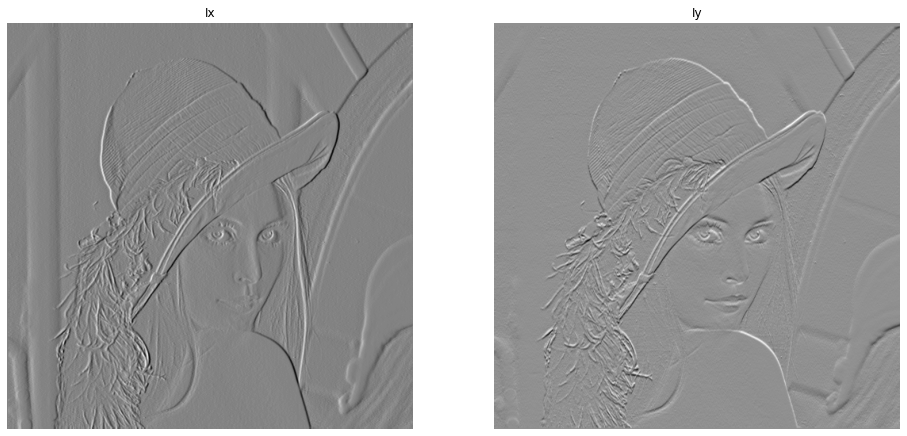

In [14]:

Ix = signal.convolve2d(img, kx, boundary='symm', mode='same')
Iy = signal.convolve2d(img, ky, boundary='symm', mode='same')

plt.figure(figsize=(16,12))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("Ix")
plt.imshow(Ix, cmap='gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Iy")
plt.imshow(Iy, cmap='gray')

plt.show()

## 3-3. Gradient magnitude

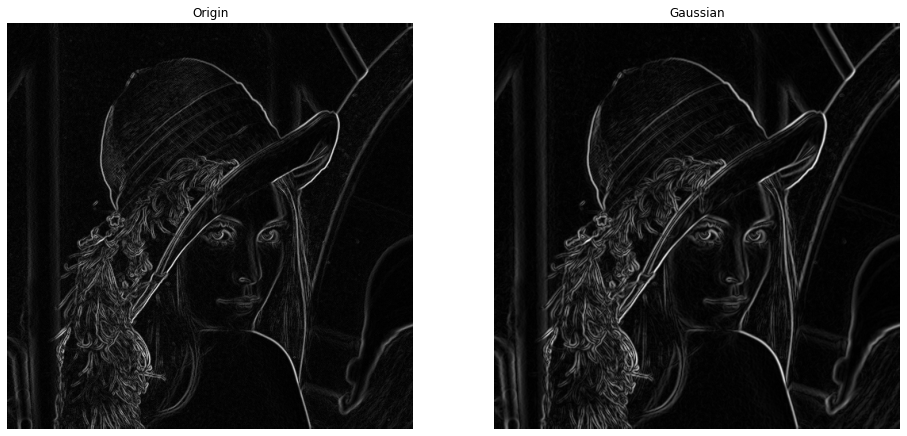

In [15]:
Ix = signal.convolve2d(img, kx, boundary='symm', mode='same')
Iy = signal.convolve2d(img, ky, boundary='symm', mode='same')
Im_origin = (Ix**2+Iy**2)**0.5

plt.figure(figsize=(16,12))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("Origin")
plt.imshow(Im_origin, cmap='gray')

Ix = signal.convolve2d(img_gaussian, kx, boundary='symm', mode='same')
Iy = signal.convolve2d(img_gaussian, ky, boundary='symm', mode='same')
Im_gaussian = (Ix**2+Iy**2)**0.5

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Gaussian")
plt.imshow(Im_gaussian, cmap='gray')

plt.show()